### Model Building and Feature Importance

,Split,RMSE (gblinear),RMSE (gbtree)
0,1,1.052671,1.105956
1,2,1.028522,1.169138
2,3,1.062047,1.133797
3,4,1.044744,1.100391
4,5,1.050570,1.148225


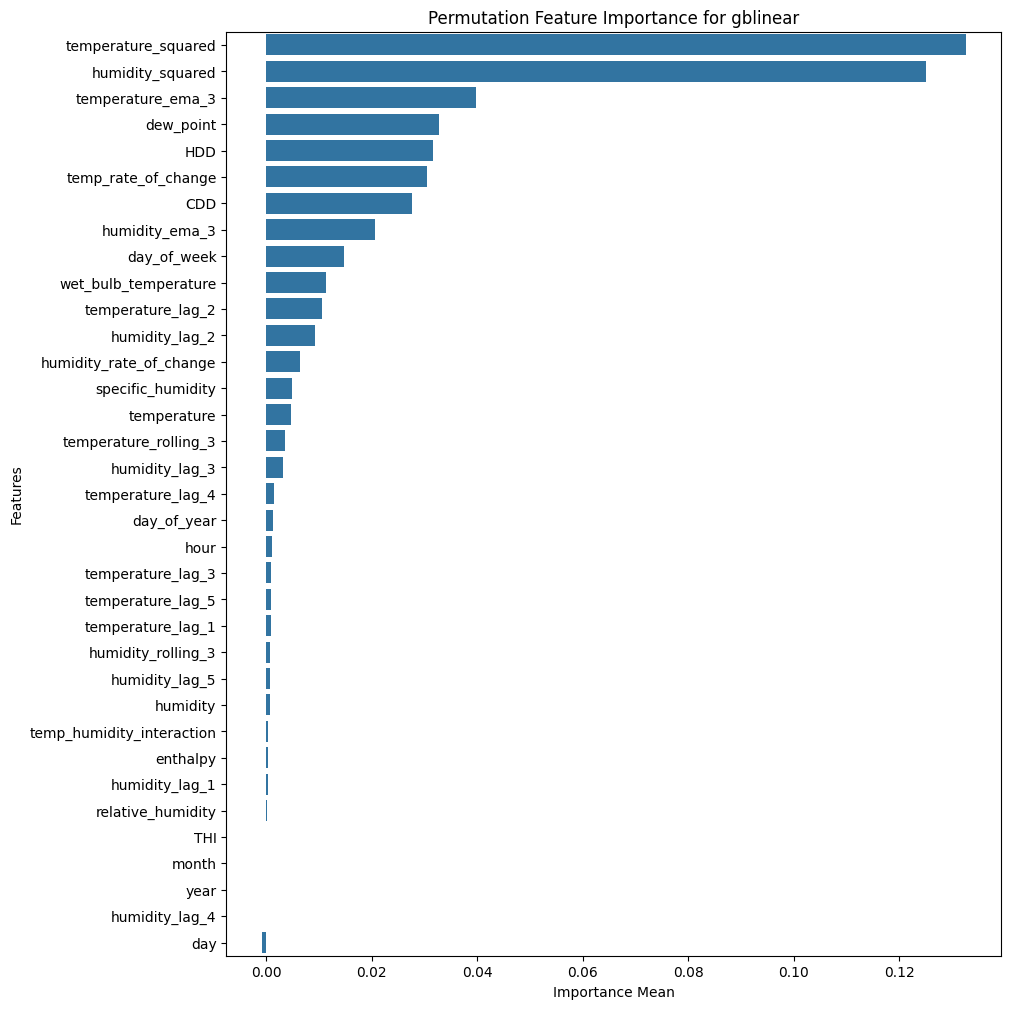

In [32]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def load_standardized_dataframe(file_name):
    """Load the standardized DataFrame from a CSV file."""
    df_standardized = pd.read_csv(file_name)
    display(HTML(f"<strong>DataFrame loaded from {file_name}</strong>"))
    return df_standardized

def determine_n_splits(n_rows):
    """Determine the number of splits based on the size of the dataset."""
    if n_rows < 500:
        return 10
    elif 500 <= n_rows < 1000:
        return 5
    elif 1000 <= n_rows < 10000:
        return 3
    else:
        return 1

def filter_allowed_dtypes(df):
    """Filter DataFrame to only include numeric and allowed dtypes."""
    return df.select_dtypes(include=[np.number])

def time_series_split_and_evaluate(df, target_column):
    """Perform time series split and evaluate gblinear and gbtree models."""
    df_filtered = filter_allowed_dtypes(df)  # Filter to only numeric columns
    X = df_filtered.drop(columns=[target_column])  # Features
    y = df[target_column]  # Target variable

    n_splits = determine_n_splits(len(df))
    display(HTML(f"<strong>Using {n_splits} splits based on the dataset size of {len(df)} rows.</strong>"))
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    rmse_gblinear = []
    rmse_gbtree = []

    # Create models with default settings
    model_gblinear = XGBRegressor(booster='gblinear', objective='reg:squarederror')
    model_gbtree = XGBRegressor(booster='gbtree', objective='reg:squarederror')

    # Time hyperparameter optimization
    start_time = time.time()

    # Perform time series split and evaluate models
    for i, (train_index, test_index) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit gblinear model
        model_gblinear.fit(X_train, y_train)
        y_pred_gblinear = model_gblinear.predict(X_test)
        rmse_gblinear.append(np.sqrt(mean_squared_error(y_test, y_pred_gblinear)))
        
        # Fit gbtree model
        model_gbtree.fit(X_train, y_train)
        y_pred_gbtree = model_gbtree.predict(X_test)
        rmse_gbtree.append(np.sqrt(mean_squared_error(y_test, y_pred_gbtree)))
    
    # Calculate time taken for hyperparameter optimization
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 2)
    
    # Display the time in seconds for hyperparameter optimization
    display(HTML(f"<strong>Time for hyperparameter optimization: {elapsed_time} seconds</strong>"))

    # Create DataFrame to display RMSE results for each split
    rmse_df = pd.DataFrame({
        "Split": np.arange(1, n_splits + 1),
        "RMSE (gblinear)": rmse_gblinear,
        "RMSE (gbtree)": rmse_gbtree
    })
    display(rmse_df)

    # Average RMSE across all splits
    avg_rmse_gblinear = np.mean(rmse_gblinear)
    avg_rmse_gbtree = np.mean(rmse_gbtree)
    
    # Display average RMSE
    display(HTML(f"<strong>Average RMSE for gblinear: {avg_rmse_gblinear:.4f}</strong>"))
    display(HTML(f"<strong>Average RMSE for gbtree: {avg_rmse_gbtree:.4f}</strong>"))
    
    # Determine the best model based on RMSE
    if avg_rmse_gblinear < avg_rmse_gbtree:
        display(HTML("<strong style='color:green;'>gblinear performs better based on RMSE.</strong>"))
        best_model = model_gblinear
    else:
        display(HTML("<strong style='color:green;'>gbtree performs better based on RMSE.</strong>"))
        best_model = model_gbtree
    
    # Perform Permutation Feature Importance for the best model (assuming gblinear is best)
    display(HTML("<h3>Permutation Feature Importance for gblinear:</h3>"))
    perm_importance = permutation_importance(best_model, X, y, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

    # Convert to DataFrame for better visualization
    perm_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance Mean': perm_importance.importances_mean,
        'Importance Std': perm_importance.importances_std
    }).sort_values(by='Importance Mean', ascending=False)

    # Plot Permutation Feature Importance with a taller plot
    plt.figure(figsize=(10, 12))  # Adjusted to make it taller
    sns.barplot(x='Importance Mean', y='Feature', data=perm_df)
    plt.title('Permutation Feature Importance for gblinear')
    plt.xlabel('Importance Mean')
    plt.ylabel('Features')
    plt.show()

def main():
    # Load the standardized DataFrame
    df = load_standardized_dataframe('df_standardized.csv')
    
    # Perform time series split and evaluate models
    time_series_split_and_evaluate(df, target_column='energy_consumption')  # Replace with your target column

if __name__ == "__main__":
    main()
